In [161]:
library("tidyverse")
library("DT")
library("ggplot2")
library("dplyr")
library(cluster)
library(pheatmap)
library(tigris)
library(sf)
library(geojsonio)
library(ggmap)

In [11]:
snapshot_urlfile = "https://raw.githubusercontent.com/ncliu95/smu_dm_project_2/main/texas_snapshot_with_census_pol.csv"

In [113]:
snapshot_cases <- read_csv(url(snapshot_urlfile))

Rows: 254 Columns: 270
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr    (9): county_name.x, state.x, state.y, state_po, county_name.y, office...
dbl  (250): county_fips_code, state_fips_code, confirmed_cases, deaths, geo_...
lgl   (10): pop_5_years_over, speak_only_english_at_home, speak_spanish_at_h...
date   (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [114]:
snapshot_cases <- snapshot_cases %>% mutate(
  cases_per_1000 = confirmed_cases/total_pop*1000, 
  deaths_per_1000 = deaths/total_pop*1000, 
  death_per_case = deaths/confirmed_cases,
    hispanic_ratio = hispanic_pop/total_pop)

In [115]:
# Download county data for Texas
tx_counties <- counties(state = "TX")
tx_counties$GEOID <- as.numeric(tx_counties$GEOID)
snapshot_cases <- left_join(snapshot_cases, tx_counties[, c("GEOID", "ALAND")], by = c("county_fips_code" = "GEOID"))
snapshot_cases <- snapshot_cases %>% mutate(
  pop_density = total_pop/ALAND)
    

Retrieving data for the year 2021



In [195]:
data <- select(snapshot_cases, 
                  "county_name.x", 
                  "median_income", 
                  "cases_per_1000", 
               "deaths_per_1000",
               "death_per_case",
               "hispanic_ratio",
               "pop_density",
                  "party", 
                  "median_age", 
                  "poverty", 
               "bachelors_degree",
                  "commuters_by_public_transportation")

In [196]:
data <- data %>% mutate(party = ifelse(party == "REPUBLICAN", 0, 1))

In [234]:
data <- data %>%
  mutate(
    median_income = scale(median_income),
    cases_per_1000 = scale(cases_per_1000),
    deaths_per_1000 = scale(deaths_per_1000),
    death_per_case = scale(death_per_case),
    hispanic_ratio = scale(hispanic_ratio),
    pop_density = scale(pop_density),
    median_age = scale(median_age),
    poverty = scale(poverty),
    bachelors_degree = scale(bachelors_degree),
    commuters_by_public_transportation = scale(commuters_by_public_transportation)
  )

In [237]:
summary(data)

 county_name.x       median_income.V1    cases_per_1000.V1  deaths_per_1000.V1 
 Length:254         Min.   :-2.068821   Min.   :-2.447022   Min.   :-1.875675  
 Class :character   1st Qu.:-0.623757   1st Qu.:-0.722137   1st Qu.:-0.663324  
 Mode  :character   Median :-0.130502   Median :-0.153612   Median :-0.129283  
                    Mean   : 0.000000   Mean   : 0.000000   Mean   : 0.000000  
                    3rd Qu.: 0.481873   3rd Qu.: 0.611281   3rd Qu.: 0.544310  
                    Max.   : 3.606019   Max.   : 3.981612   Max.   : 4.477342  
  death_per_case.V1   hispanic_ratio.V1     pop_density.V1        party        
 Min.   :-1.835994   Min.   :-1.3370682   Min.   :-0.338593   Min.   :0.00000  
 1st Qu.:-0.734352   1st Qu.:-0.7165567   1st Qu.:-0.319769   1st Qu.:0.00000  
 Median :-0.154037   Median :-0.3503962   Median :-0.274825   Median :0.00000  
 Mean   : 0.000000   Mean   : 0.0000000   Mean   : 0.000000   Mean   :0.08661  
 3rd Qu.: 0.459270   3rd Qu.: 0.6547446 

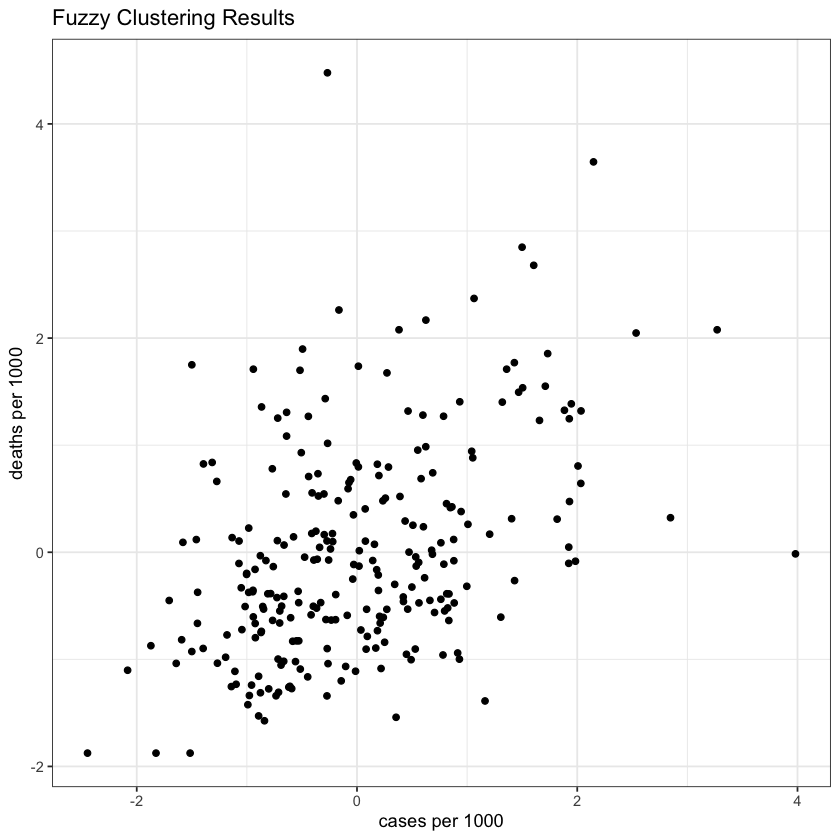

In [212]:
library(cluster)
library(ggplot2)

# Read in the data
df <- data

# Select the columns to use for clustering
vars <- c( 
                  "median_income", 
                  "cases_per_1000", 
               "deaths_per_1000",
               "death_per_case",
               "hispanic_ratio",
               "pop_density",
                  "party", 
                  "median_age", 
                  "poverty", 
               "bachelors_degree",
                  "commuters_by_public_transportation")
# Remove any rows with missing data
df <- na.omit(df[, c("county_name.x", vars)])

# Perform fuzzy clustering with 2 clusters
set.seed(123) # for reproducibility
clusters <- fanny(df[, vars], k = 4, memb.exp = 1.5)

# Add the cluster assignments to the original data frame
df$cluster <- clusters$membership

# Create a scatter plot of confirmed cases vs. median income, colored by cluster
ggplot(df, aes(x = cases_per_1000, y = deaths_per_1000)) + 
  geom_point() +
  labs(title = "Fuzzy Clustering Results", x = "cases per 1000", y = "deaths per 1000") +
  theme_bw()

In [213]:
df

county_name.x,median_income,cases_per_1000,deaths_per_1000,death_per_case,hispanic_ratio,pop_density,party,median_age,poverty,bachelors_degree,commuters_by_public_transportation,cluster
<chr>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>",<dbl>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,4]>"
Anderson County,-0.6248695,0.70412124,-0.56257111,-0.83576536,-0.74179778,-0.17737708,0,0.01352820,-0.15445574,-0.19129400,-0.14939225,"0.2709650, 0.18710499, 0.2709650, 0.2709650"
Andrews County,1.7192137,0.50781469,0.25258255,-0.12306615,0.89861041,-0.30410512,0,-1.24360478,-0.22971254,-0.24160068,-0.15773407,"0.2193259, 0.34202250, 0.2193258, 0.2193259"
Angelina County,-0.2820762,-0.03230575,0.34929891,0.28516094,-0.55957472,-0.01217613,0,-0.37199258,-0.01043969,-0.12826316,-0.13078359,"0.2721643, 0.18350707, 0.2721643, 0.2721643"
Aransas County,-0.4362878,-1.59199856,-0.81708223,0.32390377,-0.32198479,-0.04608123,0,1.77351438,-0.19463508,-0.21037042,-0.15773407,"0.2882134, 0.13535946, 0.2882136, 0.2882135"
Archer County,1.0960205,0.03557059,-0.72585412,-0.76466362,-1.12790518,-0.30998480,0,0.96894927,-0.25007359,-0.23257379,-0.15473957,"0.2876903, 0.13692914, 0.2876903, 0.2876903"
Armstrong County,1.5541223,-0.44152423,1.26907563,1.64917756,-1.05732088,-0.33261415,0,1.15332878,-0.25982766,-0.24997857,-0.15773407,"0.2677530, 0.19674109, 0.2677530, 0.2677530"
Atascosa County,0.4368090,0.02103344,0.01454635,-0.06621630,1.24890401,-0.22158319,0,-0.60665740,-0.15405255,-0.19709559,-0.15452568,"0.2077136, 0.37685926, 0.2077135, 0.2077136"
Austin County,1.0483806,-1.14078069,-1.25439003,-0.88278466,-0.36928182,-0.20423544,0,0.31524012,-0.20165988,-0.19416530,-0.15602292,"0.2870695, 0.13879144, 0.2870696, 0.2870695"
Bailey County,-0.5251388,1.00754035,0.26092131,-0.33295503,1.21088490,-0.31340718,0,-0.64018095,-0.23828806,-0.24523896,-0.15773407,"0.1728836, 0.48134946, 0.1728834, 0.1728835"


In [214]:
counties <- as_tibble(map_data("county"))
counties_TX <- counties %>% dplyr::filter(region == "texas") %>% 
  rename(c(county = subregion))

In [215]:
df <- df %>% mutate(county = county_name.x %>% 
    str_to_lower() %>% str_replace('\\s+county\\s*$', ''))

counties_TX_clust <- counties_TX %>% left_join(df)

Joining with `by = join_by(county)`


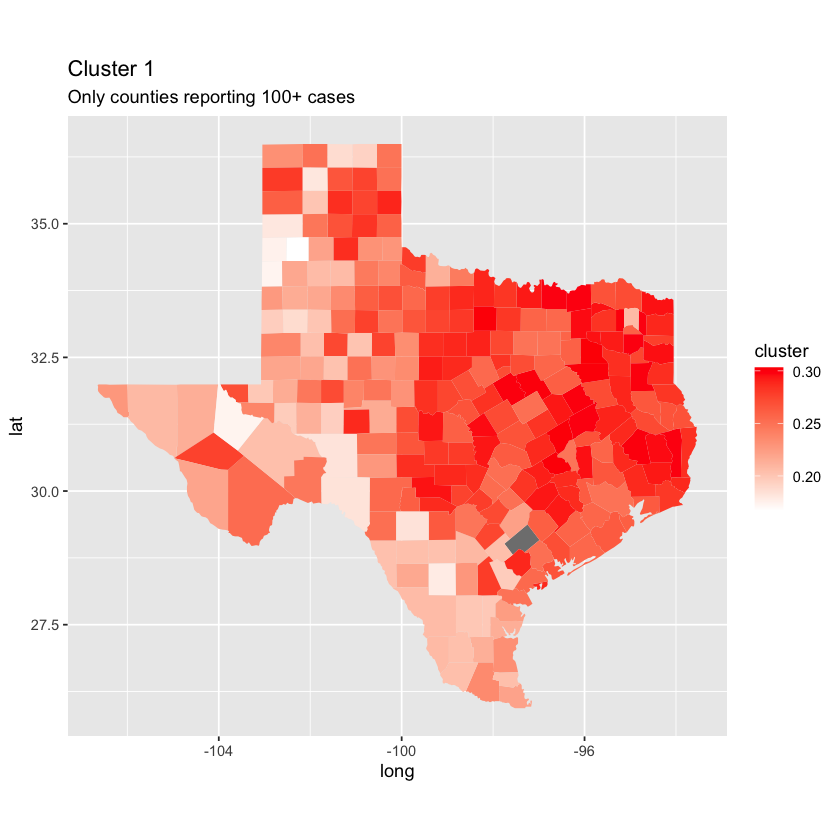

In [233]:
counties_TX_clust_1 <- counties_TX_clust %>% mutate(cluster = cluster[,1])
ggplot(counties_TX_clust_1, aes(long, lat)) + 
  geom_polygon(data = counties_TX_clust_1, aes(x = long, y = lat, group = group, fill = cluster)) +
  coord_quickmap() + 
  scale_fill_gradient(low = "white", high = "red") +
  labs(title = "Cluster 1", subtitle = "Only counties reporting 100+ cases")

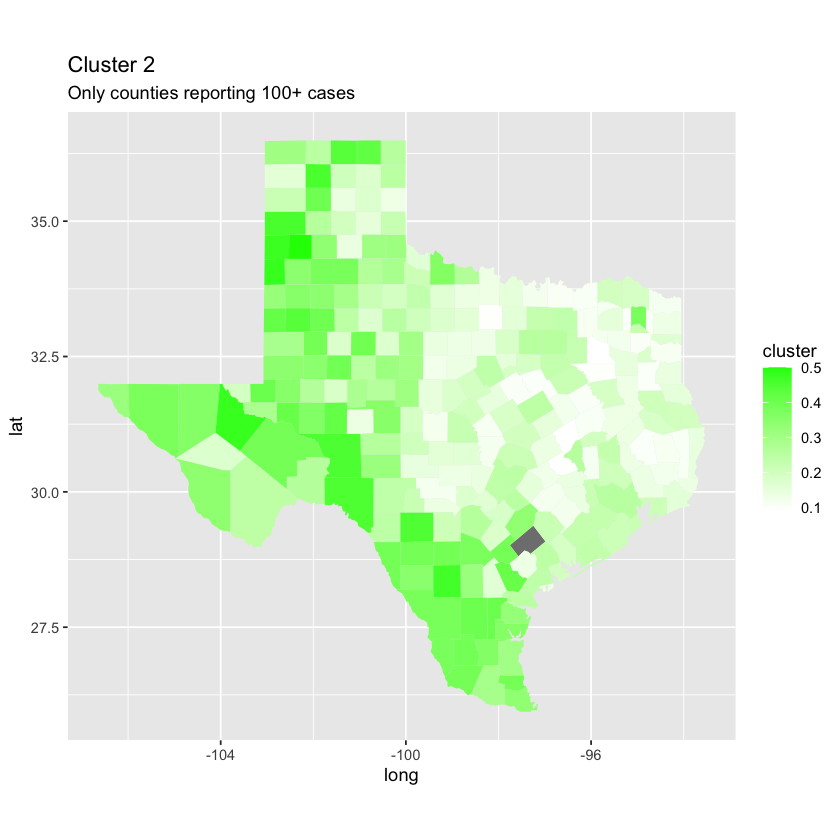

In [232]:
counties_TX_clust_2 <- counties_TX_clust %>% mutate(cluster = cluster[,2])
ggplot(counties_TX_clust_2, aes(long, lat)) + 
  geom_polygon(data = counties_TX_clust_2, aes(x = long, y = lat, group = group, fill = cluster)) +
  coord_quickmap() + 
  scale_fill_gradient(low = "white", high = "green") +
  labs(title = "Cluster 2", subtitle = "Only counties reporting 100+ cases")

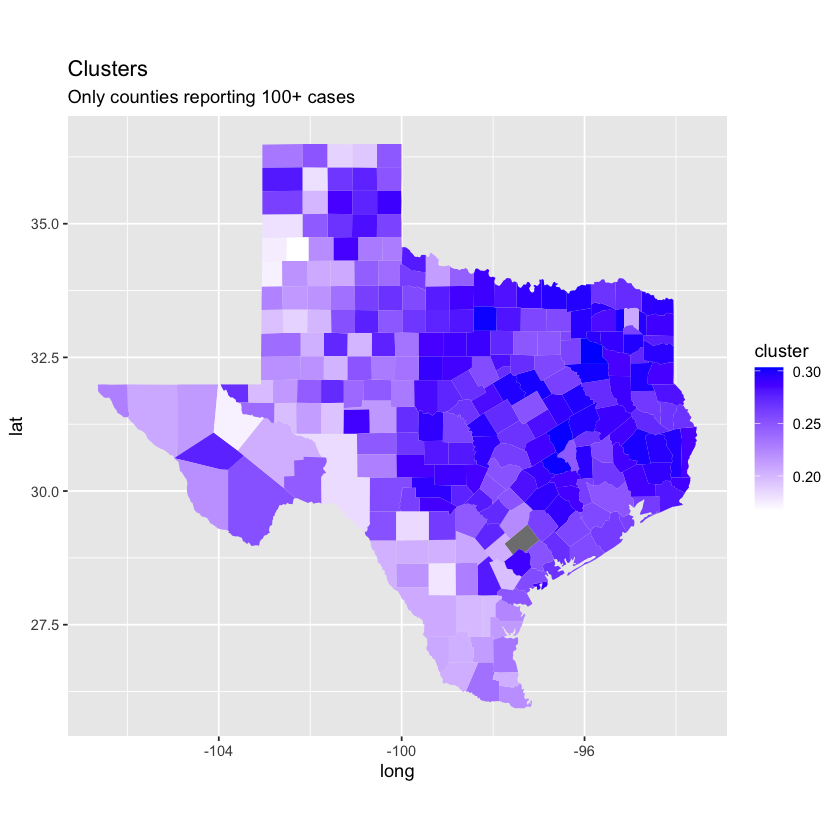

In [225]:
counties_TX_clust_3 <- counties_TX_clust %>% mutate(cluster = cluster[,3])
ggplot(counties_TX_clust_3, aes(long, lat)) + 
  geom_polygon(data = counties_TX_clust_3, aes(x = long, y = lat, group = group, fill = cluster)) +
  coord_quickmap() + 
  scale_fill_gradient(low = "white", high = "blue") +
  labs(title = "Clusters", subtitle = "Only counties reporting 100+ cases")

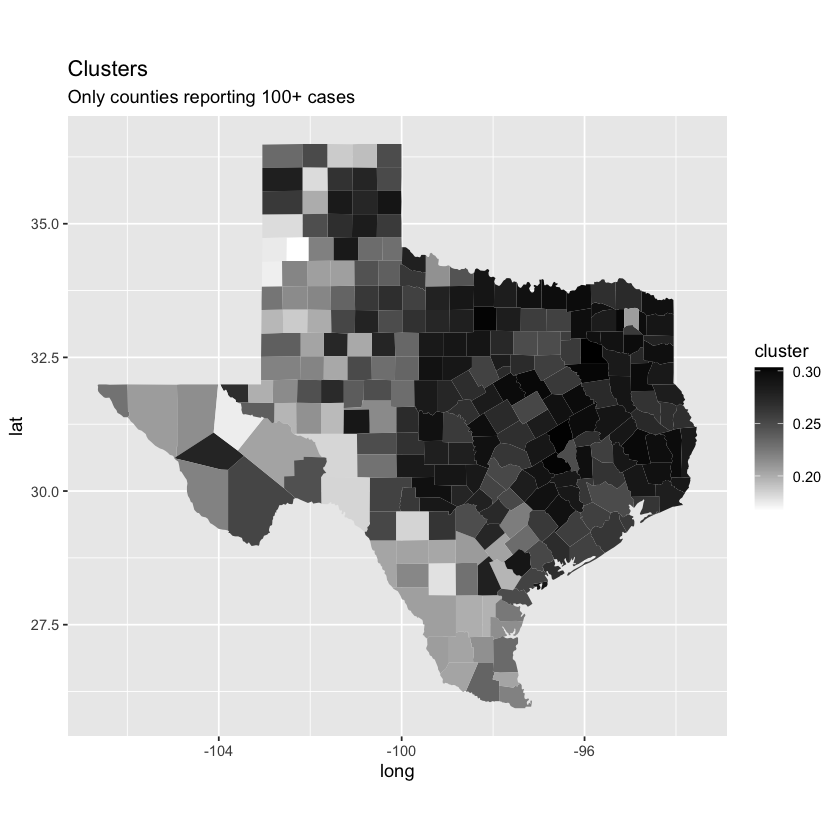

In [231]:
counties_TX_clust_4 <- counties_TX_clust %>% mutate(cluster = cluster[,4])
ggplot(counties_TX_clust_4, aes(long, lat)) + 
  geom_polygon(data = counties_TX_clust_4, aes(x = long, y = lat, group = group, fill = cluster)) +
  coord_quickmap() + 
  scale_fill_gradient(low = "white", high = "black") +
  labs(title = "Clusters", subtitle = "Only counties reporting 100+ cases")